<a href="https://colab.research.google.com/github/nurayuasyifa/data-science-portofolio/blob/main/Mini_Project_3_Nur_Ayu_Asyifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict Customer Personality to Boost Marketing Campaign by Using Machine Learning**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


conversion rate merupakan berapa total respon dengan total visit pada platform. Setelah melakukn feature engineering, dapat dilihat dengan menggunakan scatterplot hubungan umur dengan conversion rate, income dengan conversion rate, dll.

# Import Package and Dataset

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_columns',None)

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Rakamin Academy/JAP/Mini Project 3/marketing_campaign_data.csv')

# Check Dataset

In [4]:
dataset.shape

(2240, 30)

In [5]:
dataset.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,0,5524,1957,S1,Lajang,58138000.0,0,0,04-09-2012,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,1,2174,1954,S1,Lajang,46344000.0,1,1,08-03-2014,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,2,4141,1965,S1,Bertunangan,71613000.0,0,0,21-08-2013,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,3,6182,1984,S1,Bertunangan,26646000.0,1,0,10-02-2014,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,4,5324,1981,S3,Menikah,58293000.0,1,0,19-01-2014,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# Feature Engineering

In [6]:
df = dataset.copy()

In [7]:
nums=[]
cats=[]
for i in df.columns:
  if (i == 'Response') or (i == 'Unnamed: 0') or (i == 'ID'):
    continue
  else:
    if df[i].dtype == 'object':
      cats.append(i)
    else:
      nums.append(i)

In [8]:
#total purchase
df['TotalPurchase'] = df['NumWebPurchases']+df['NumCatalogPurchases']+df['NumStorePurchases']+df['NumWebVisitsMonth']

#conversion rate
def div(x,y):
    if y == 0:
        return 0
    return round(x*100/y,2)
df['ConversionRate(%)'] = df.apply(lambda x : div(x['TotalPurchase'],x['NumWebVisitsMonth']),axis=1)

#menambah feature age
df['Age'] = df['Year_Birth'].apply(lambda x: 2022 - int(x))

#age group
def agegroup(x):
  if x['Age'] >= 70:
    group = 'Over Seventy'
  elif x['Age'] >= 60 and x['Age'] < 70:
      group = 'Sixty'
  elif x['Age'] >= 50 and x['Age'] < 60:
      group = 'Fifty'
  elif x['Age'] >= 40 and x['Age'] < 50:
      group = 'Fourty'
  elif x['Age'] >= 30 and x['Age'] < 40:
      group = 'Thirty'
  else:
    group = 'Late Twenty'
  return group

df['AgeGroup'] = df.apply(lambda x: agegroup(x), axis=1)

nums = ['Late Twenty','Thirty','Fourty','Fifty','Sixty','Over Seventy']
df['AgeGroup'] = pd.Categorical(df['AgeGroup'], categories=nums, ordered=True)

#menambah feature anak
df['NumsChildren']=df['Kidhome']+df['Teenhome']

#total spending
df['TotalExpenses'] = df['MntCoke']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']

#expenses group
def spending(x):
  if x['TotalExpenses'] >= 2000000:
    group = '> 2 juta'
  elif x['TotalExpenses'] >= 1000000 and x['TotalExpenses'] < 2000000:
      group = '1 - 2 juta'
  else:
    group = '< 1 juta'
  return group

df['SpendingGroup'] = df.apply(lambda x: spending(x), axis=1)

spending = ['< 1 juta','1 - 2 juta','> 2 juta']
df['SpendingGroup'] = pd.Categorical(df['SpendingGroup'], categories=spending, ordered=True)

#income group
def income(x):
  if x['Income'] > 60000000:
    group = '> 60 juta'
  elif (x['Income'] >= 35000000) and (x['Income'] < 60000000):
      group = '35 - 60 juta'
  else:
    group = '< 35 juta'
  return group

df['IncomeGroup'] = df.apply(lambda x: income(x), axis=1)

income = ['< 35 juta','35 - 60 juta','> 60 juta']
df['IncomeGroup'] = pd.Categorical(df['IncomeGroup'], categories=income, ordered=True)

#seniority
import datetime
from datetime import date
last_date = date(2022,4,22)
df['Seniority']=pd.to_datetime(df['Dt_Customer'], dayfirst=True,format = '%d-%m-%Y')
df['Seniority'] = pd.to_numeric(df['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')//365

#total campaign acc
df["AcceptedCampaigns"]= df["AcceptedCmp1"]+df["AcceptedCmp2"]+df["AcceptedCmp3"]+df["AcceptedCmp4"]+df["AcceptedCmp5"]

# Exploratory Data Analysis (EDA)

### Distribusi feature `Age`

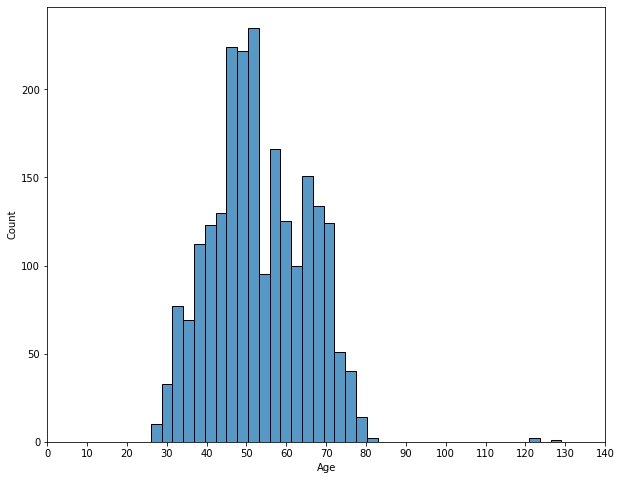

In [9]:
plt.figure(figsize=(10,8))
sns.histplot(x=df['Age'])
plt.xticks(range(0,150,10))
plt.show()

In [10]:
df.Age.describe()

count    2240.000000
mean       53.194196
std        11.984069
min        26.000000
25%        45.000000
50%        52.000000
75%        63.000000
max       129.000000
Name: Age, dtype: float64

## Distribusi feature `Age Group`

In [11]:
dfa = df.groupby('AgeGroup').agg({'ID':'count','ConversionRate(%)':'mean'}).rename(columns={'ID':'Total'}).reset_index()
dfa['%cust'] = dfa['Total']*100/np.sum(dfa['Total'])
dfa[['AgeGroup','ConversionRate(%)','%cust']]

,AgeGroup,ConversionRate(%),%cust
0,Late Twenty,903.630000,0.669643
1,Thirty,507.121713,12.767857
2,Fourty,414.845032,27.678571
3,Fifty,449.481645,27.678571
4,Sixty,545.133161,20.758929
5,Over Seventy,639.087949,10.446429


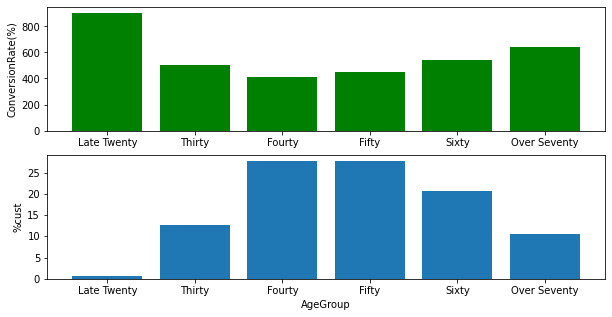

In [12]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
ax[0].bar(x='AgeGroup',height='ConversionRate(%)',data=dfa,color='green')
ax[1].bar(x='AgeGroup',height='%cust',data=dfa)
plt.xlabel('AgeGroup')
ax[0].set_ylabel('ConversionRate(%)')
ax[1].set_ylabel('%cust')
plt.show()

Analisis berfokus pada grup usia (`AgeGroup`) dan Conversion Rate. Conversion rate tertinggi ada pada grup usia 'Late Twenty' yaitu sebesar 14%. Sedangkan untuk

## Total Purchases

In [13]:
df['TotalPurchase'].describe()

count    2240.000000
mean       17.853571
std         6.550998
min         0.000000
25%        12.000000
50%        17.000000
75%        23.000000
max        38.000000
Name: TotalPurchase, dtype: float64

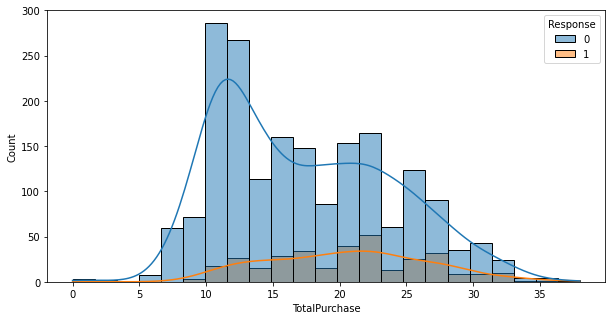

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(x='TotalPurchase',hue='Response',data=df,kde=True)
plt.show()

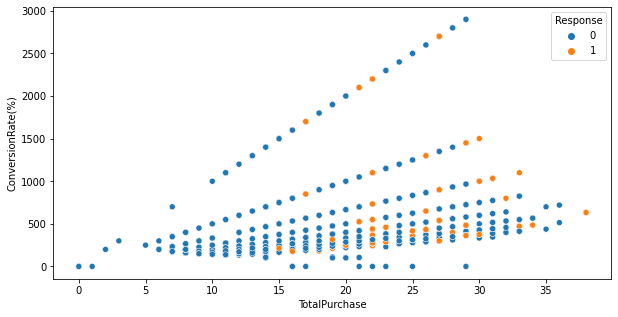

In [15]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='TotalPurchase',y='ConversionRate(%)',hue='Response',data=df)
plt.show()

Analisis berfokus pada hubungan antara Total Pembelian (`TotalPurchase`) dengan conversion rate. Semakin besar barnag yang dibeli maka conversion ratenya juga akan semakin tinggi.

## Distribusi Jumlah Anak

In [16]:
df['NumsChildren'].describe()

count    2240.000000
mean        0.950446
std         0.751803
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: NumsChildren, dtype: float64

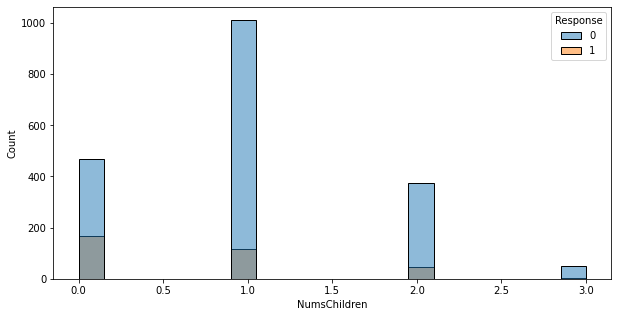

In [17]:
plt.figure(figsize=(10,5))
sns.histplot(x='NumsChildren',hue='Response',data=df)
plt.show()

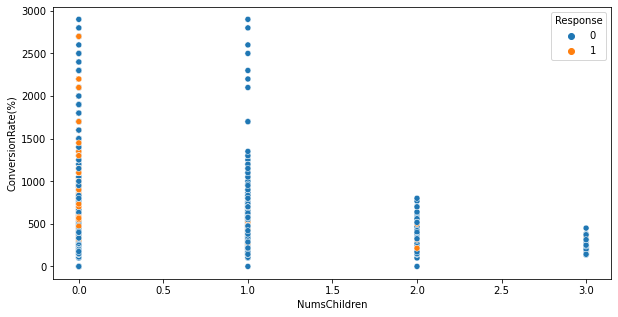

In [18]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='NumsChildren',y='ConversionRate(%)',hue='Response',data=df)
plt.show()

Customer yang memiliki `ConvertionRate` paling tinggi ada pada customer yang tidak memiliki anak (`NumsChildren`=0). Semakin banyak seorang customer memiliki anak, maka `ConvertionRate`nya semakin menurun.

## Total Spending vs Conversion Rate

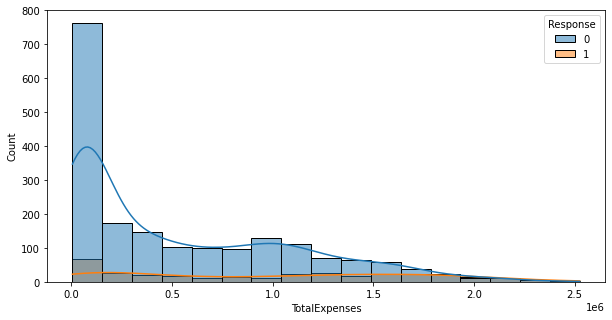

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(x='TotalExpenses',hue='Response',data=df,kde=True)
plt.show()

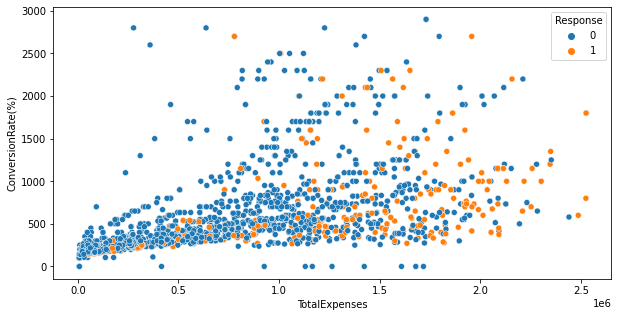

In [20]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='TotalExpenses',y='ConversionRate(%)',hue='Response',data=df)
plt.show()

In [21]:
df['TotalExpenses'].describe()

count    2.240000e+03
mean     6.057982e+05
std      6.022493e+05
min      5.000000e+03
25%      6.875000e+04
50%      3.960000e+05
75%      1.045500e+06
max      2.525000e+06
Name: TotalExpenses, dtype: float64

In [22]:
df.groupby('SpendingGroup').agg({'ConversionRate(%)':'mean'}).reset_index()

,SpendingGroup,ConversionRate(%)
0,< 1 juta,334.802503
1,1 - 2 juta,897.505761
2,> 2 juta,1073.552400


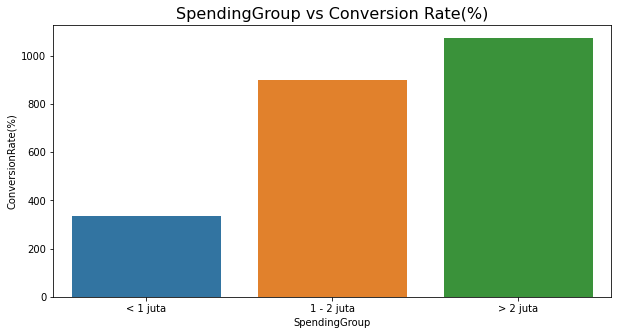

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(x='SpendingGroup',y='ConversionRate(%)',data=df,ci=None)
plt.title('SpendingGroup vs Conversion Rate(%)',fontsize=16)
plt.show()

Analisis ini berfokus pada hubungan anatara grup total pengeluaran (`SpendingGroup`) dengan conversion rate. Semakin besar total pengeluaran pelanggan maka semakin besar pula convertion ratenya. Sehingga untuk pelanggan yang ada pada `SpendingGroup` '1-2 juta'  dapat diberi treatment (seperti promo pembelanjaan lebih dari 2 juat mendapat voucher diskon) agar mereka dapat masuk ke grup '>2 juta'.

## Income vs Conversion Rate

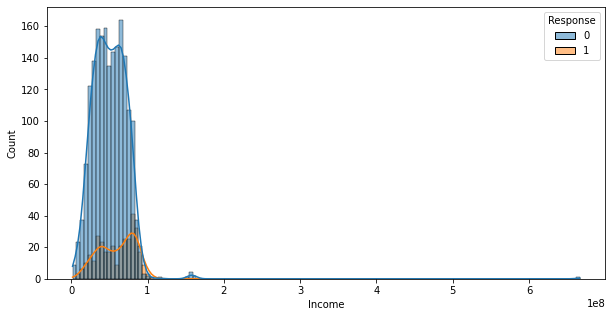

In [24]:
plt.figure(figsize=(10,5))
sns.histplot(x='Income',hue='Response',data=df,kde=True)
plt.show()

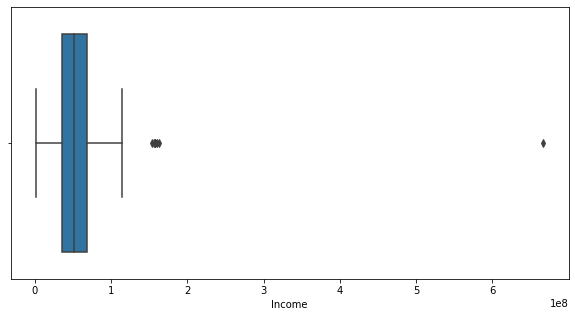

In [25]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Income',data=df)
plt.show()

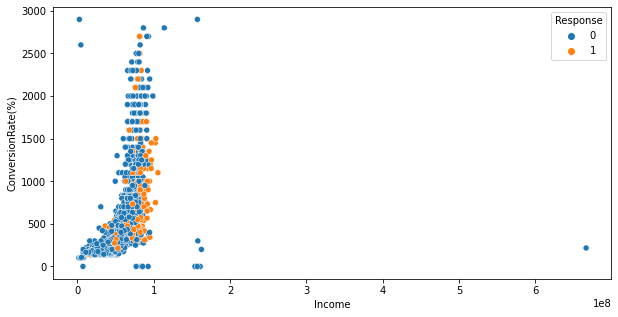

In [26]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='Income',y='ConversionRate(%)',hue='Response',data=df)
plt.show()

In [27]:
df['Income'].describe()

count    2.216000e+03
mean     5.224725e+07
std      2.517308e+07
min      1.730000e+06
25%      3.530300e+07
50%      5.138150e+07
75%      6.852200e+07
max      6.666660e+08
Name: Income, dtype: float64

In [28]:
df.groupby('IncomeGroup').agg({'ConversionRate(%)':'mean'}).reset_index()

,IncomeGroup,ConversionRate(%)
0,< 35 juta,205.070226
1,35 - 60 juta,297.156788
2,> 60 juta,873.534649


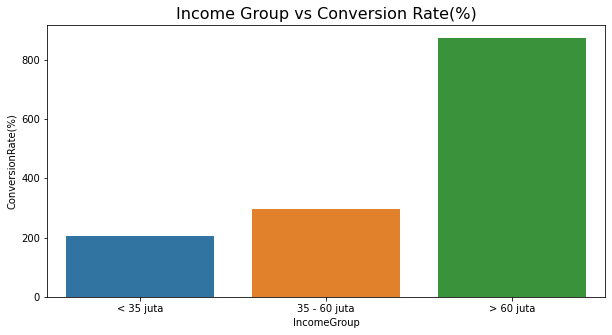

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(x='IncomeGroup',y='ConversionRate(%)',data=df,ci=None)
plt.title('Income Group vs Conversion Rate(%)',fontsize=16)
plt.show()

Analisis berfokus pada hubungan antara grup penghasilan (`IncomeGroup`) dengan conversion rate. Semakin besar penghasilan pelanggan maka akan semakin besar pula convesion ratenya. untuk pelanggan yeng berpenghasilan lebih dari 60 juta, memiliki rata-rata coversion rate 9%. Perbedaannya sangat signifikan dibandingkan pelanggan yang ada pada `IncomeGroup` '<35 juta'  dan '335-60 juta' yang rata-rata conversion ratenya 1%

## Seniority vs Conversion Rate

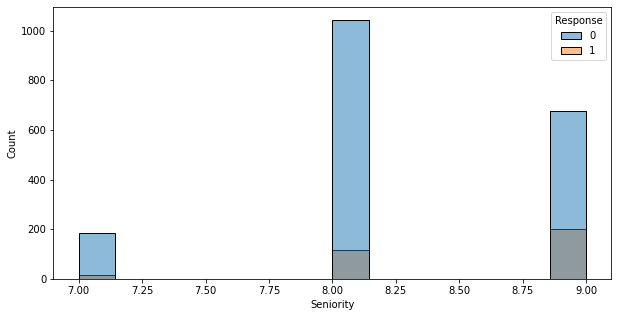

In [30]:
plt.figure(figsize=(10,5))
sns.histplot(x=df['Seniority'],hue=df['Response'])
plt.show()

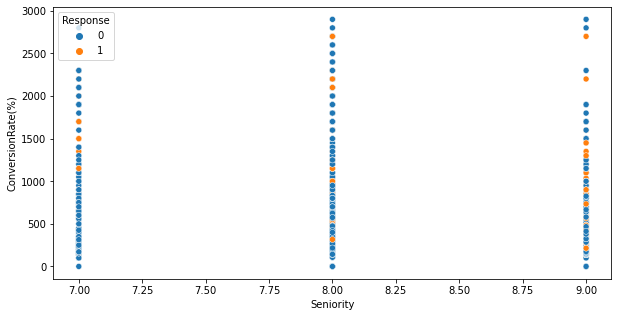

In [31]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='Seniority',y='ConversionRate(%)',hue='Response',data=df)
plt.show()

## Campaign vs Conversion Rate

In [32]:
dfa = df.groupby(['Response','AcceptedCampaigns']).agg({'ID':'count',
                                                        'ConversionRate(%)':'mean'}).rename(columns={'ID':'Total'}).reset_index().sort_values(['Response','AcceptedCampaigns'])
dfa['%'] = round(dfa['Total']*100/np.sum(dfa['Total']),3)
dfa

,Response,AcceptedCampaigns,Total,ConversionRate(%),%
0,0,0,1631,432.896579,72.812
1,0,1,224,642.133438,10.000
2,0,2,41,842.688537,1.830
3,0,3,9,1280.000000,0.402
4,0,4,1,500.000000,0.045
5,1,0,146,475.950685,6.518
6,1,1,101,546.204257,4.509
7,1,2,42,874.568810,1.875
8,1,3,35,875.500857,1.562
9,1,4,10,901.501000,0.446


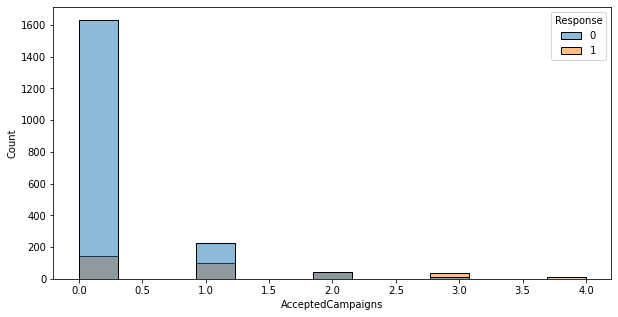

In [33]:
plt.figure(figsize=(10,5))
sns.histplot(x=df['AcceptedCampaigns'],hue=df['Response'])
plt.show()

Semakin banyak campaign yang diterima maka conversion rate juga akan semakin tinggi

## Feature Engineering: Marital Status

In [34]:
df.groupby('Marital_Status').agg({'ID':'count'}).rename(columns={'ID':'Total'}).reset_index().sort_values('Total')

,Marital_Status,Total
2,Duda,3
3,Janda,77
1,Cerai,232
4,Lajang,484
0,Bertunangan,580
5,Menikah,864


In [35]:
df['Marital_Status'].replace({'Duda':'Lajang',
                              'Janda':'Lajang',
                              'Cerai':'Lajang'},inplace=True)

In [36]:
dfms = df.groupby(['Response','Marital_Status']).agg({'ID':'count',
                                         'ConversionRate(%)':'mean'}).rename(columns={'ID':'Total'}).reset_index().sort_values(['Response','ConversionRate(%)'])
dfms['%'] = round(dfms['Total']*100/np.sum(dfms['Total']),3)
dfms

,Response,Marital_Status,Total,ConversionRate(%),%
1,0,Lajang,620,465.897710,27.679
2,0,Menikah,766,465.916645,34.196
0,0,Bertunangan,520,482.141750,23.214
3,1,Bertunangan,60,516.216667,2.679
5,1,Menikah,98,561.081939,4.375
4,1,Lajang,176,653.896761,7.857


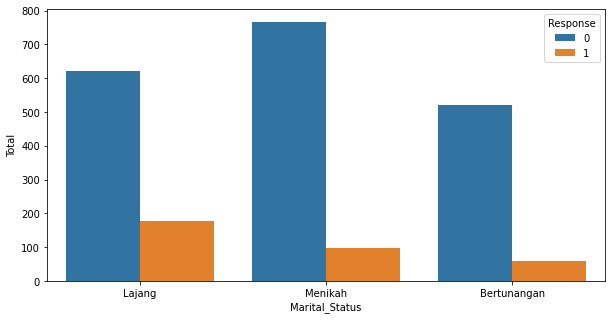

In [37]:
plt.figure(figsize=(10,5))
sns.barplot(x=dfms['Marital_Status'],y=dfms['Total'],hue=dfms['Response'])
plt.show()

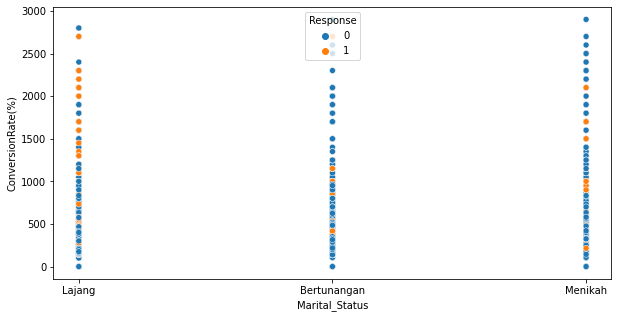

In [38]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='Marital_Status',y='ConversionRate(%)',hue='Response',data=df)
plt.show()

# Cleaning Data and Preprocessing

In [138]:
dfc = df.copy()

## Handling Null Values

In [139]:
total = dfc.isnull().sum().sort_values(ascending=False)
p = round(100*df.isnull().sum().sort_values(ascending=False)/df.shape[0],3)
missing_data = pd.concat([total,p],axis=1,join='outer',keys=['Total Missing Count','% of Total Observations']).reset_index().rename(columns={'index':'Feature'})
feature_with_null_value = missing_data[missing_data['% of Total Observations']>0]
feature_with_null_value

,Feature,Total Missing Count,% of Total Observations
0,Income,24,1.071


In [140]:
dfc.Z_Revenue.unique()

array([11])

In [141]:
dfc.Z_CostContact.unique()

array([3])

In [142]:
dfc.columns

Index(['Unnamed: 0', 'ID', 'Year_Birth', 'Education', 'Marital_Status',
       'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntCoke',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'TotalPurchase', 'ConversionRate(%)', 'Age', 'AgeGroup', 'NumsChildren',
       'TotalExpenses', 'SpendingGroup', 'IncomeGroup', 'Seniority',
       'AcceptedCampaigns'],
      dtype='object')

**Observations:**
* Terdapat nilai yang null pada feature `Income`
* Drop feature `Z_CostContact` dan `Z_Revenue` karena memiliki nilai yang konstan sehingga tidak ada informasi yang dapat digali pada feature tersebut
* Drop feature `Unnamed: 0`,`Year_Birth`, `Kidhome`, `Teenhome`, dan `Dt_Customer`

In [143]:
dfc.dropna(subset=['Income'],inplace=True)

In [144]:
dfc.isnull().sum().sum()

0

## Check Duplicate

In [145]:
dfc.duplicated().sum()

0

## Encoding

In [146]:
dfc.drop(columns=['Unnamed: 0', 'ID', 'Year_Birth','Kidhome', 'Teenhome', 
                  'Dt_Customer','Kidhome', 'Teenhome', 'Dt_Customer',
                  'Z_CostContact', 'Z_Revenue'],inplace=True)

In [147]:
dfc.shape

(2216, 32)

In [148]:
df_encode = dfc.copy()

In [149]:
#filter outliers
df_encode=df_encode[(df_encode['Income']<100000000) & (df_encode['Age']<100)]

In [150]:
df_encode.columns

Index(['Education', 'Marital_Status', 'Income', 'Recency', 'MntCoke',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'TotalPurchase',
       'ConversionRate(%)', 'Age', 'AgeGroup', 'NumsChildren', 'TotalExpenses',
       'SpendingGroup', 'IncomeGroup', 'Seniority', 'AcceptedCampaigns'],
      dtype='object')

In [151]:
nums2=[]
cats2=[]
bools2=[]
for i in df_encode.columns:
  if (df_encode[i].dtype == 'object') or (df_encode[i].dtype == 'category'):
    cats2.append(i)
  else:
    if (list(df_encode[i].unique()) == [1,0]) or (list(df_encode[i].unique()) == [0,1]):
      bools2.append(i)
    else:
      nums2.append(i)

In [152]:
print(nums2)
print(cats2)
print(bools2)

['Income', 'Recency', 'MntCoke', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'TotalPurchase', 'ConversionRate(%)', 'Age', 'NumsChildren', 'TotalExpenses', 'Seniority', 'AcceptedCampaigns']
['Education', 'Marital_Status', 'AgeGroup', 'SpendingGroup', 'IncomeGroup']
['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']


In [153]:
for col in cats2:
    print(f'value counts of column {col}')
    print(df_encode[col].value_counts())
    print('---'*10, '\n')

value counts of column Education
S1     1110
S3      474
S2      364
D3      198
SMA      54
Name: Education, dtype: int64
------------------------------ 

value counts of column Marital_Status
Menikah        854
Lajang         780
Bertunangan    566
Name: Marital_Status, dtype: int64
------------------------------ 

value counts of column AgeGroup
Fifty           611
Fourty          607
Sixty           458
Thirty          282
Over Seventy    227
Late Twenty      15
Name: AgeGroup, dtype: int64
------------------------------ 

value counts of column SpendingGroup
< 1 juta      1610
1 - 2 juta     540
> 2 juta        50
Name: SpendingGroup, dtype: int64
------------------------------ 

value counts of column IncomeGroup
> 60 juta       826
35 - 60 juta    824
< 35 juta       550
Name: IncomeGroup, dtype: int64
------------------------------ 



In [154]:
mapping1 = {
    'SMA' : 0,
    'D3' : 1,
    'S1' : 2,
    'S2' : 3,
    'S3' : 4
}
df_encode['Education_mapped'] = df_encode['Education'].map(mapping1)
mapping2 = {
    '< 35 juta' : 0,
    '35 - 60 juta' : 1,
    '> 60 juta' : 2
}
df_encode['IncomeGroup_mapped'] = df_encode['IncomeGroup'].map(mapping2)
mapping3 = {
    '< 1 juta' : 0,
    '1 - 2 juta' : 1,
    '> 2 juta' : 2
}
df_encode['SpendingGroup_mapped'] = df_encode['SpendingGroup'].map(mapping3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [155]:
dfc[['Education','SpendingGroup','IncomeGroup']].head()

,Education,SpendingGroup,IncomeGroup
0,S1,1 - 2 juta,35 - 60 juta
1,S1,< 1 juta,35 - 60 juta
2,S1,< 1 juta,> 60 juta
3,S1,< 1 juta,< 35 juta
4,S3,< 1 juta,35 - 60 juta


In [156]:
df_encode[['Education_mapped','SpendingGroup_mapped','IncomeGroup_mapped']].head()

,Education_mapped,SpendingGroup_mapped,IncomeGroup_mapped
0,2,1,1
1,2,0,1
2,2,0,2
3,2,0,0
4,4,0,1


In [157]:
df_encode = df_encode.drop(columns=['Education','SpendingGroup','IncomeGroup'])
df_encode.shape

(2200, 32)

In [158]:
#OHE (ps:run sekali saja)
for cat in ['Marital_Status', 'AgeGroup']:
    onehots = pd.get_dummies(df_encode[cat], prefix=cat)
    df_encode = df_encode.join(onehots)

In [159]:
df_encode[['Marital_Status_Bertunangan', 'Marital_Status_Lajang',
       'Marital_Status_Menikah', 'AgeGroup_Late Twenty', 'AgeGroup_Thirty',
       'AgeGroup_Fourty', 'AgeGroup_Fifty', 'AgeGroup_Sixty',
       'AgeGroup_Over Seventy']].head()

,Marital_Status_Bertunangan,Marital_Status_Lajang,Marital_Status_Menikah,AgeGroup_Late Twenty,AgeGroup_Thirty,AgeGroup_Fourty,AgeGroup_Fifty,AgeGroup_Sixty,AgeGroup_Over Seventy
0,0,1,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,1,0,0
3,1,0,0,0,1,0,0,0,0
4,0,0,1,0,0,1,0,0,0


In [160]:
df_encode.columns

Index(['Marital_Status', 'Income', 'Recency', 'MntCoke', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'TotalPurchase',
       'ConversionRate(%)', 'Age', 'AgeGroup', 'NumsChildren', 'TotalExpenses',
       'Seniority', 'AcceptedCampaigns', 'Education_mapped',
       'IncomeGroup_mapped', 'SpendingGroup_mapped',
       'Marital_Status_Bertunangan', 'Marital_Status_Lajang',
       'Marital_Status_Menikah', 'AgeGroup_Late Twenty', 'AgeGroup_Thirty',
       'AgeGroup_Fourty', 'AgeGroup_Fifty', 'AgeGroup_Sixty',
       'AgeGroup_Over Seventy'],
      dtype='object')

In [161]:
df_encode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2200 entries, 0 to 2239
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Marital_Status              2200 non-null   object  
 1   Income                      2200 non-null   float64 
 2   Recency                     2200 non-null   int64   
 3   MntCoke                     2200 non-null   int64   
 4   MntFruits                   2200 non-null   int64   
 5   MntMeatProducts             2200 non-null   int64   
 6   MntFishProducts             2200 non-null   int64   
 7   MntSweetProducts            2200 non-null   int64   
 8   MntGoldProds                2200 non-null   int64   
 9   NumDealsPurchases           2200 non-null   int64   
 10  NumWebPurchases             2200 non-null   int64   
 11  NumCatalogPurchases         2200 non-null   int64   
 12  NumStorePurchases           2200 non-null   int64   
 13  NumWebVisitsMonth 

In [162]:
df_encode['IncomeGroup_mapped']=df_encode['IncomeGroup_mapped'].astype('int16')

In [163]:
df_encode['SpendingGroup_mapped']=df_encode['SpendingGroup_mapped'].astype('int16')

In [164]:
df_encode = df_encode.drop(columns=['AgeGroup','Marital_Status'])
df_encode.shape

(2200, 39)

## Standardization

In [165]:
df_std = df_encode.copy()

In [166]:
nums3=[]
bools3=[]
for i in df_std.columns:
    if (list(df_std[i].unique()) == [1,0]) or (list(df_std[i].unique()) == [0,1]):
      bools3.append(i)
    else:
      nums3.append(i)

In [167]:
to_std = nums3
from sklearn.preprocessing import StandardScaler
for i in range(0,len(to_std)):
  df_std[to_std[i]] = StandardScaler().fit_transform(df_std[to_std[i]].values.reshape(len(df_std), 1))

In [168]:
df_encode[nums3].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Income,2200.0,5.150031e+07,2.057713e+07,1730000.0,35178000.00,51222500.0,68130000.0,98777000.0
Recency,2200.0,4.904182e+01,2.893252e+01,0.0,24.00,49.0,74.0,99.0
MntCoke,2200.0,3.056477e+05,3.372135e+05,0.0,24000.00,177500.0,505000.0,1493000.0
MntFruits,2200.0,2.628727e+04,3.960460e+04,0.0,2000.00,8000.0,33000.0,199000.0
MntMeatProducts,2200.0,1.653282e+05,2.179146e+05,0.0,16000.00,68000.0,232000.0,1725000.0
MntFishProducts,2200.0,3.768091e+04,5.476303e+04,0.0,3000.00,12000.0,50000.0,259000.0
MntSweetProducts,2200.0,2.687045e+04,4.061839e+04,0.0,1000.00,8000.0,33000.0,198000.0
MntGoldProds,2200.0,4.389182e+04,5.155450e+04,0.0,9000.00,25000.0,56000.0,321000.0
NumDealsPurchases,2200.0,2.323182e+00,1.885443e+00,0.0,1.00,2.0,3.0,15.0
NumWebPurchases,2200.0,4.085000e+00,2.693288e+00,0.0,2.00,4.0,6.0,25.0


In [169]:
df_std[nums3].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Income,2200.0,-5.040160e-17,1.000227,-2.419270,-0.793406,-0.013504,0.808347,2.298058
Recency,2200.0,9.096259e-17,1.000227,-1.695427,-0.865722,-0.001446,0.862830,1.727107
MntCoke,2200.0,-7.615121e-17,1.000227,-0.906598,-0.835411,-0.380106,0.591310,3.521870
MntFruits,2200.0,-1.135455e-17,1.000227,-0.663894,-0.613383,-0.461851,0.169532,4.361918
MntMeatProducts,2200.0,-4.559484e-17,1.000227,-0.758856,-0.685416,-0.446736,0.306023,7.158890
MntFishProducts,2200.0,6.287899e-17,1.000227,-0.688228,-0.633435,-0.469053,0.225004,4.042315
MntSweetProducts,2200.0,-5.046468e-20,1.000227,-0.661685,-0.637060,-0.464685,0.150940,4.214063
MntGoldProds,2200.0,-1.006770e-17,1.000227,-0.851561,-0.676949,-0.366527,0.234915,5.376275
NumDealsPurchases,2200.0,-2.373102e-16,1.000227,-1.232448,-0.701948,-0.171448,0.359052,6.725050
NumWebPurchases,2200.0,-8.122291e-17,1.000227,-1.517078,-0.774323,-0.031567,0.711189,7.767367


# Modelling

In [170]:
df_cluster = df_encode.copy()

In [171]:
df_cluster.columns

Index(['Income', 'Recency', 'MntCoke', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'TotalPurchase', 'ConversionRate(%)', 'Age',
       'NumsChildren', 'TotalExpenses', 'Seniority', 'AcceptedCampaigns',
       'Education_mapped', 'IncomeGroup_mapped', 'SpendingGroup_mapped',
       'Marital_Status_Bertunangan', 'Marital_Status_Lajang',
       'Marital_Status_Menikah', 'AgeGroup_Late Twenty', 'AgeGroup_Thirty',
       'AgeGroup_Fourty', 'AgeGroup_Fifty', 'AgeGroup_Sixty',
       'AgeGroup_Over Seventy'],
      dtype='object')

In [172]:
df_cluster_1 = df_cluster[['Income','NumDealsPurchases','NumWebVisitsMonth','Complain',
                           'Response','TotalPurchase', 'ConversionRate(%)', 'Age',
                          'NumsChildren', 'TotalExpenses', 'Seniority', 'AcceptedCampaigns',
                          'Education_mapped', 'Marital_Status_Bertunangan', 'Marital_Status_Lajang',
                          'Marital_Status_Menikah']]


[2.583164790793381e+17, 1.3175043575996837e+17, 7.749250069194512e+16, 5.06908939449204e+16, 3.760194407576206e+16, 2.8826839254158464e+16, 2.2391566689497524e+16, 1.7702721787822956e+16, 1.4162941975024488e+16]


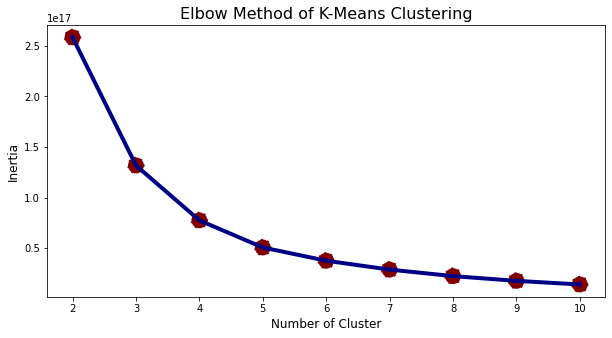

In [173]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_cluster_1)
    inertia.append(kmeans.inertia_)
print(inertia)

plt.figure(figsize=(10, 5))
# plt.plot(inertia)

sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')
plt.title('Elbow Method of K-Means Clustering',fontsize=16)
plt.ylabel('Inertia',fontsize=12)
plt.xlabel('Number of Cluster',fontsize=12)
plt.xticks(range(2,11))
plt.show()

In [174]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df_cluster_1.values)

KMeans(n_clusters=4, random_state=0)

In [175]:
df1 = df_encode.copy()
df1['Cluster'] = kmeans.labels_
df
df1.head()

,Income,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,TotalPurchase,ConversionRate(%),Age,NumsChildren,TotalExpenses,Seniority,AcceptedCampaigns,Education_mapped,IncomeGroup_mapped,SpendingGroup_mapped,Marital_Status_Bertunangan,Marital_Status_Lajang,Marital_Status_Menikah,AgeGroup_Late Twenty,AgeGroup_Thirty,AgeGroup_Fourty,AgeGroup_Fifty,AgeGroup_Sixty,AgeGroup_Over Seventy,Cluster
0,58138000.0,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,1,29,414.29,65,0,1617000,9,0,2,1,1,0,1,0,0,0,0,0,1,0,1
1,46344000.0,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,0,9,180.00,68,2,27000,8,0,2,1,0,0,1,0,0,0,0,0,1,0,0
2,71613000.0,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,0,24,600.00,57,0,776000,8,0,2,2,0,1,0,0,0,0,0,1,0,0,2
3,26646000.0,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,0,12,200.00,38,1,53000,8,0,2,0,0,1,0,0,0,1,0,0,0,0,3
4,58293000.0,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,0,19,380.00,41,1,422000,8,0,4,1,0,0,0,1,0,0,1,0,0,0,1


In [176]:
# Value Counting of Each Categorical-type Column
for col in ['Cluster']:
    print(f'''Value count column {col}:''')
    print(df1[col].value_counts())
    print('---'*10, '\n')

Value count column Cluster:
0    640
1    605
2    508
3    447
Name: Cluster, dtype: int64
------------------------------ 



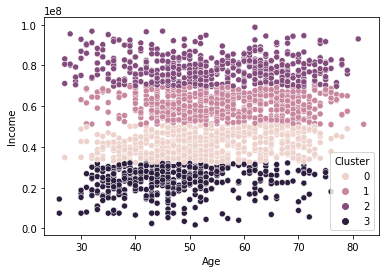

In [177]:
sns.scatterplot(data=df1, x='Age', y='Income', hue='Cluster')

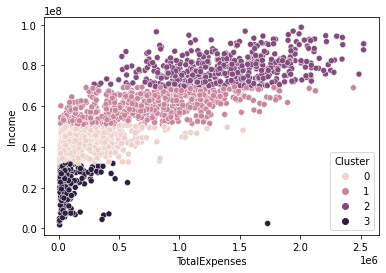

In [178]:
sns.scatterplot(data=df1, x='TotalExpenses', y='Income', hue='Cluster')

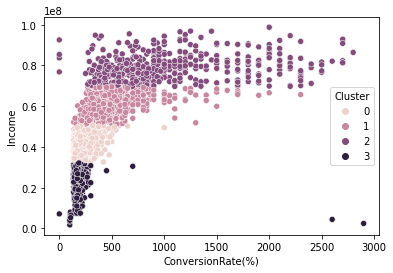

In [179]:
sns.scatterplot(data=df1, x='ConversionRate(%)', y='Income', hue='Cluster')

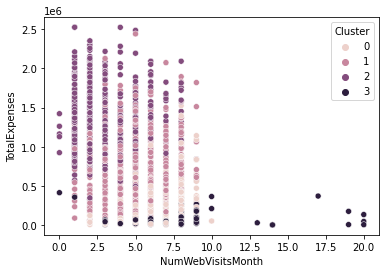

In [180]:
sns.scatterplot(data=df1, x='NumWebVisitsMonth', y='TotalExpenses', hue='Cluster')

[0.6120350248529584, 0.5505699064775833, 0.5384272679556431, 0.5397193489440357, 0.5233155446318195, 0.515730760812791, 0.5175566751916421, 0.5198673242020864, 0.5237659337551803]


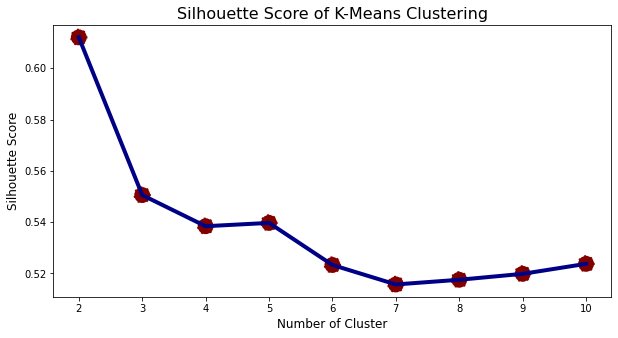

In [181]:
from sklearn.metrics import silhouette_score

results = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    predict = kmeans.fit_predict(df_cluster_1)
    silhouette = silhouette_score(df_cluster_1, predict)
    results.append(silhouette)
print(results)
plt.figure(figsize=(10, 5))
# plt.plot(inertia)

sns.lineplot(x=range(2, 11), y=results, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=results, s=300, color='#800000',  linestyle='--')
plt.title('Silhouette Score of K-Means Clustering',fontsize=16)
plt.ylabel('Silhouette Score',fontsize=12)
plt.xlabel('Number of Cluster',fontsize=12)
plt.xticks(range(2,11))
plt.show()

In [182]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df_cluster_1.values)

KMeans(n_clusters=4, random_state=0)

In [183]:
df2 = df_encode.copy()
df2['Cluster'] = kmeans.labels_
df2.head()

,Income,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,TotalPurchase,ConversionRate(%),Age,NumsChildren,TotalExpenses,Seniority,AcceptedCampaigns,Education_mapped,IncomeGroup_mapped,SpendingGroup_mapped,Marital_Status_Bertunangan,Marital_Status_Lajang,Marital_Status_Menikah,AgeGroup_Late Twenty,AgeGroup_Thirty,AgeGroup_Fourty,AgeGroup_Fifty,AgeGroup_Sixty,AgeGroup_Over Seventy,Cluster
0,58138000.0,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,1,29,414.29,65,0,1617000,9,0,2,1,1,0,1,0,0,0,0,0,1,0,1
1,46344000.0,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,0,9,180.00,68,2,27000,8,0,2,1,0,0,1,0,0,0,0,0,1,0,0
2,71613000.0,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,0,24,600.00,57,0,776000,8,0,2,2,0,1,0,0,0,0,0,1,0,0,2
3,26646000.0,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,0,12,200.00,38,1,53000,8,0,2,0,0,1,0,0,0,1,0,0,0,0,3
4,58293000.0,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,0,19,380.00,41,1,422000,8,0,4,1,0,0,0,1,0,0,1,0,0,0,1


In [184]:
# Value Counting of Each Categorical-type Column
for col in ['Cluster']:
    print(f'''Value count column {col}:''')
    print(df2[col].value_counts())
    print('---'*10, '\n')

Value count column Cluster:
0    640
1    605
2    508
3    447
Name: Cluster, dtype: int64
------------------------------ 



For n_clusters = 2 The average silhouette_score is : 0.6120350248529584
For n_clusters = 3 The average silhouette_score is : 0.5505699064775833
For n_clusters = 4 The average silhouette_score is : 0.5384272679556431
For n_clusters = 5 The average silhouette_score is : 0.5397193489440357
For n_clusters = 6 The average silhouette_score is : 0.5233155446318195
For n_clusters = 7 The average silhouette_score is : 0.515730760812791
For n_clusters = 8 The average silhouette_score is : 0.5175566751916421
For n_clusters = 9 The average silhouette_score is : 0.5198673242020864
For n_clusters = 10 The average silhouette_score is : 0.5237659337551803


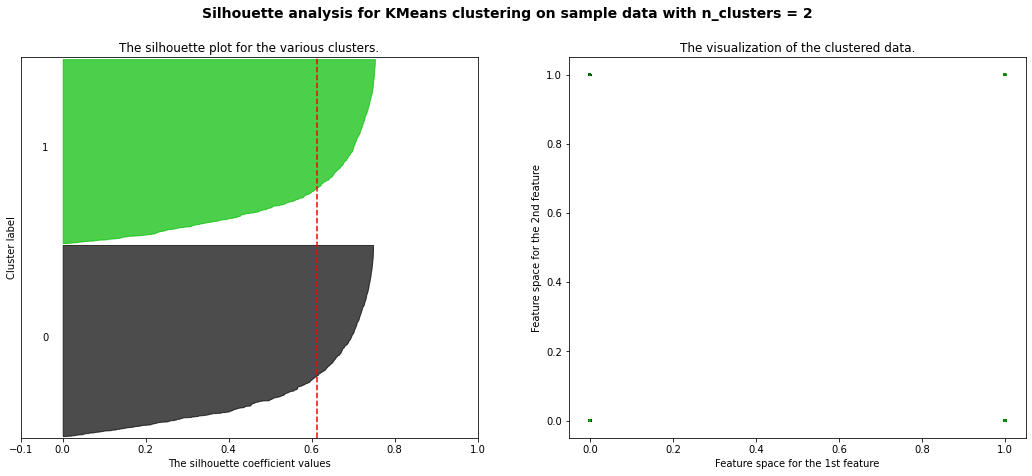

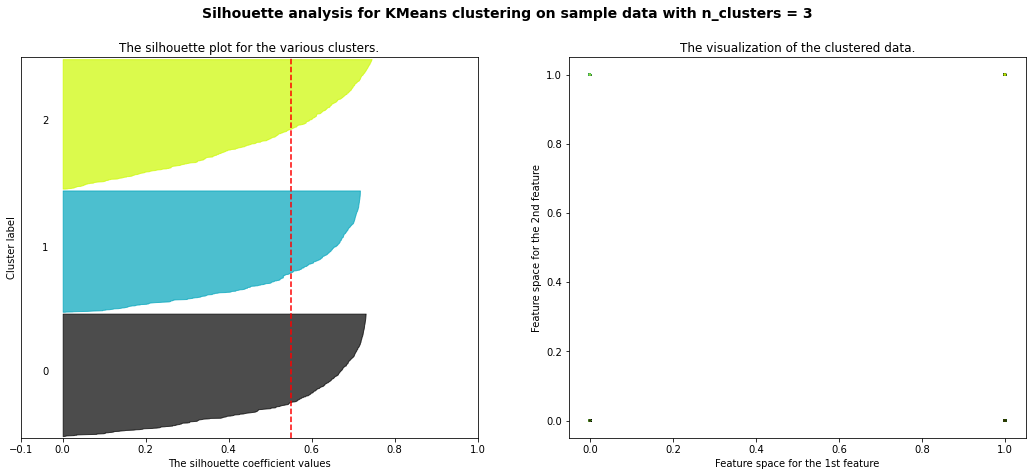

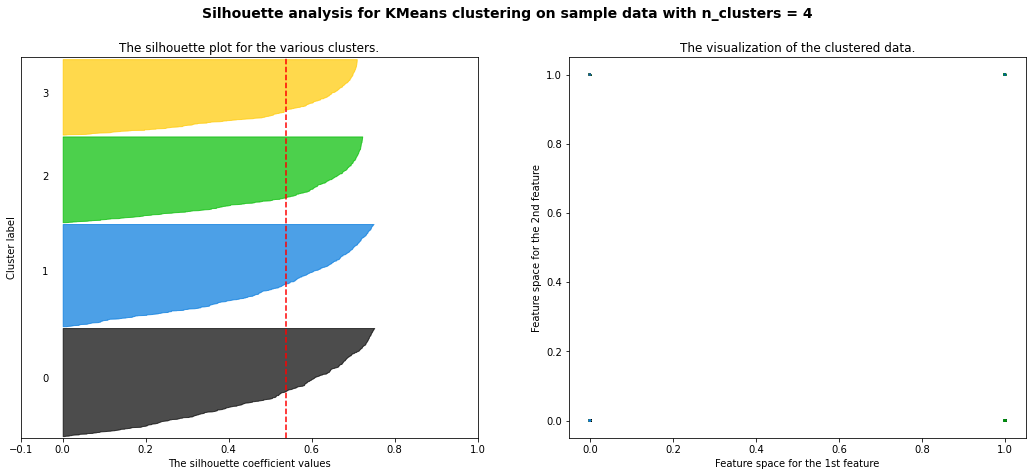

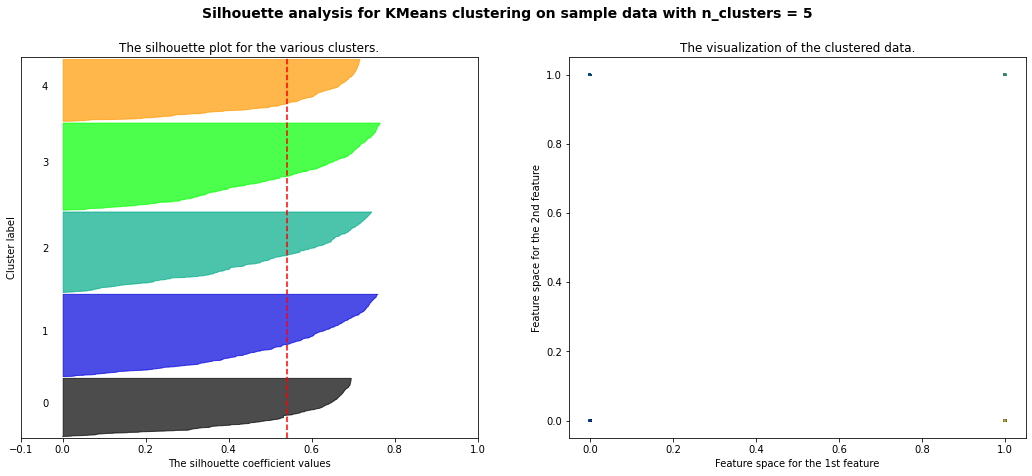

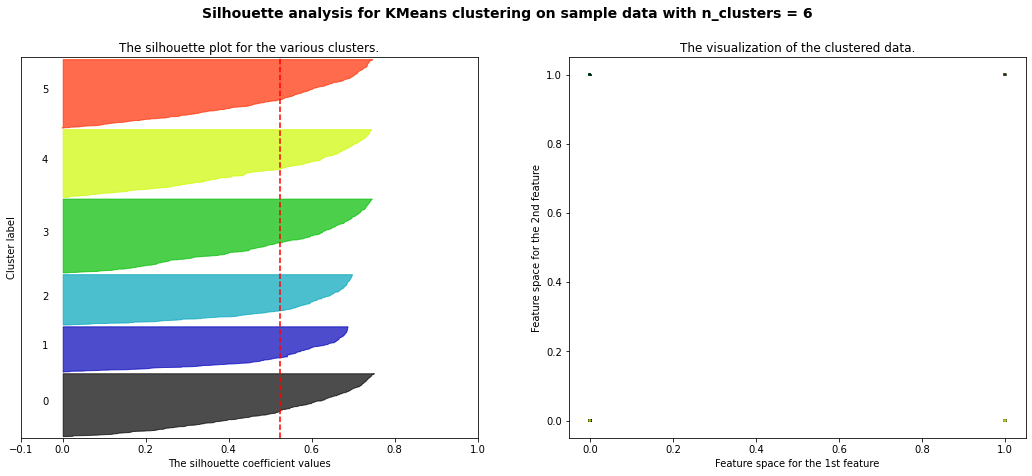

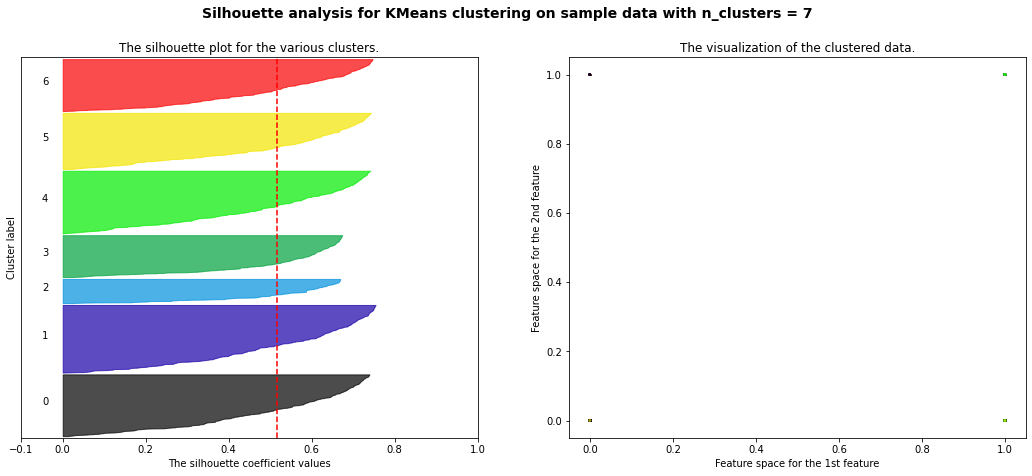

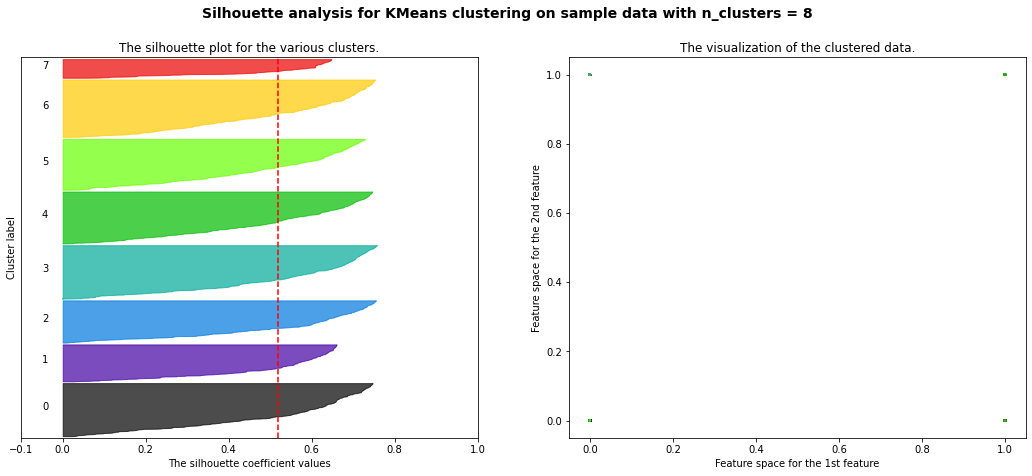

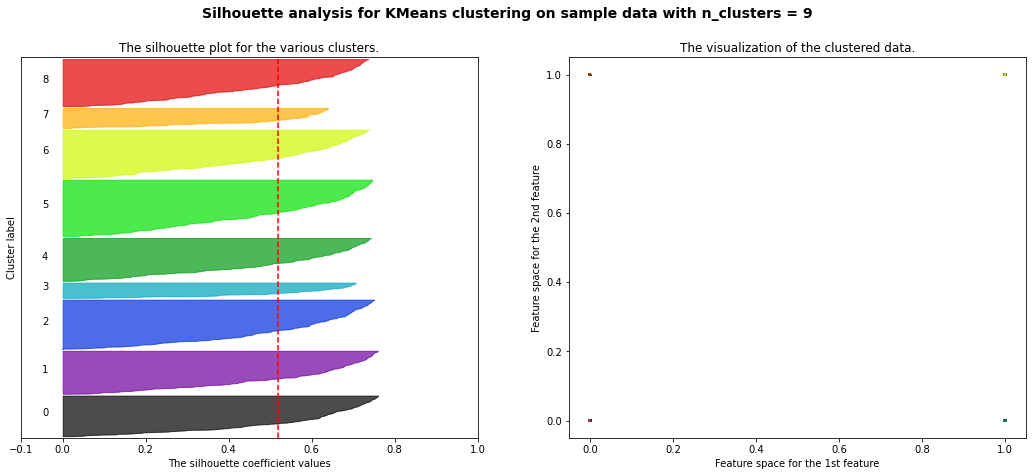

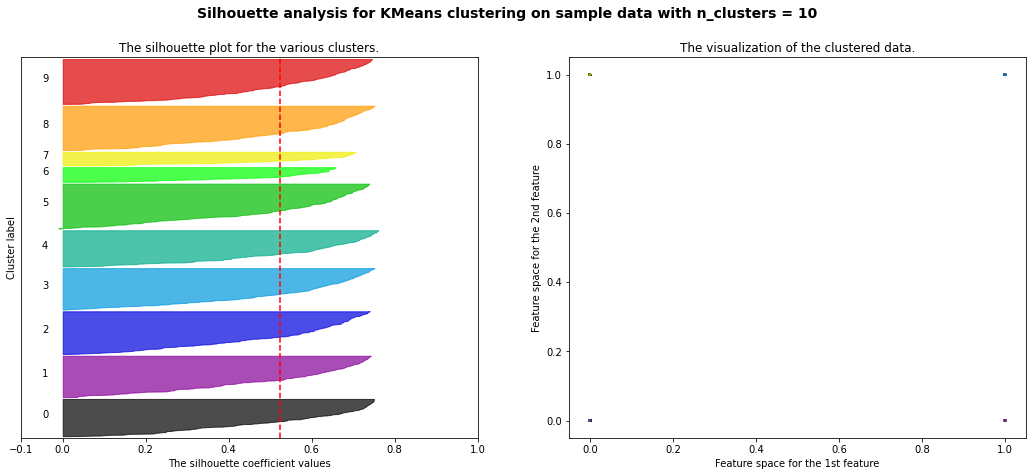

In [185]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = df_cluster_1

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 4], X.iloc[:, 15], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

        
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

# Interpretasi

In [135]:
df1.head()

,Income,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,TotalPurchase,ConversionRate(%),Age,NumsChildren,TotalExpenses,Seniority,AcceptedCampaigns,Education_mapped,IncomeGroup_mapped,SpendingGroup_mapped,Marital_Status_Bertunangan,Marital_Status_Lajang,Marital_Status_Menikah,AgeGroup_Late Twenty,AgeGroup_Thirty,AgeGroup_Fourty,AgeGroup_Fifty,AgeGroup_Sixty,AgeGroup_Over Seventy,Cluster
0,58138000.0,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,1,29,414.29,65,0,1617000,9,0,2,1,1,0,1,0,0,0,0,0,1,0,3
1,46344000.0,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,0,9,180.00,68,2,27000,8,0,2,1,0,0,1,0,0,0,0,0,1,0,0
2,71613000.0,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,0,24,600.00,57,0,776000,8,0,2,2,0,1,0,0,0,0,0,1,0,0,2
3,26646000.0,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,0,12,200.00,38,1,53000,8,0,2,0,0,1,0,0,0,1,0,0,0,0,0
4,58293000.0,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,0,19,380.00,41,1,422000,8,0,4,1,0,0,0,1,0,0,1,0,0,0,3


In [136]:
df1.columns

Index(['Income', 'Recency', 'MntCoke', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'TotalPurchase', 'ConversionRate(%)', 'Age',
       'NumsChildren', 'TotalExpenses', 'Seniority', 'AcceptedCampaigns',
       'Education_mapped', 'IncomeGroup_mapped', 'SpendingGroup_mapped',
       'Marital_Status_Bertunangan', 'Marital_Status_Lajang',
       'Marital_Status_Menikah', 'AgeGroup_Late Twenty', 'AgeGroup_Thirty',
       'AgeGroup_Fourty', 'AgeGroup_Fifty', 'AgeGroup_Sixty',
       'AgeGroup_Over Seventy', 'Cluster'],
      dtype='object')

In [137]:
df1.groupby('Cluster').agg(['count','min','mean','median','max']).reset_index()

Cluster Income                                                    Recency  \
           count         min          mean      median          max   count   
0       0   1015   3502000.0  3.480957e+07  34554000.0   70829000.0    1015   
1       1    172  48192000.0  8.372228e+07  80882000.0  666666000.0     172   
2       2    439   4428000.0  7.428679e+07  73448000.0  162397000.0     439   
3       3    590   1730000.0  5.667129e+07  57110000.0  160803000.0     590   

                            MntCoke                                          \
  min       mean median max   count   min           mean    median      max   
0   0  49.200985   49.0  99    1015     0   43540.886700   21000.0   734000   
1   0  48.005814   43.0  99     172  9000  878767.441860  908000.0  1493000   
2   0  49.758542   53.0  99     439  1000  475273.348519  445000.0  1315000   
3   0  48.427119   50.0  99     590  1000  461179.661017  386500.0  1449000   

  MntFruits                                    MntMeatProducts         \
      count min          mean   median     max           count    min   
0      1015   0   5605.911330   2000.0  103000            1015      0   
1       172   0  58337.209302  35500.0  190000             172  18000   
2       439   0  59339.407745  46000.0  197000             439   1000   
3       590   0  28188.135593  12000.0  199000             590   1000   

                                    MntFishProducts                    \
            mean    median      max           count min          mean   
0   22806.896552   14000.0   156000            1015   0   7964.532020   
1  475587.209302  455000.0   974000             172   0  87796.511628   
2  389933.940774  374000.0  1725000             439   0  86993.166287   
3  159206.779661  124000.0  1725000             590   0  37338.983051   

                   MntSweetProducts                                     \
    median     max            count min          mean   median     max   
0   3000.0  179000             1015   0   5439.408867   2000.0   78000   
1  64000.0  253000              172   0  63988.372093  44000.0  194000   
2  73000.0  258000              439   0  61170.842825  45000.0  262000   
3  17000.0  259000              590   0  27991.525424  13000.0  194000   

  MntGoldProds                                    NumDealsPurchases      \
         count min          mean   median     max             count min   
0         1015   0  16250.246305  10000.0  291000              1015   0   
1          172   0  78023.255814  58000.0  245000               172   0   
2          439   0  71328.018223  53000.0  321000               439   0   
3          590   0  61355.932203  42000.0  247000               590   1   

                       NumWebPurchases                           \
       mean median max           count min      mean median max   
0  1.883744    2.0   7            1015   0  2.129064    2.0  23   
1  1.116279    1.0   5             172   2  5.575581    5.0  11   
2  1.205011    1.0   5             439   0  4.724374    4.0  27   
3  4.264407    4.0  15             590   0  6.540678    7.0  11   

  NumCatalogPurchases                          NumStorePurchases      \
                count min      mean median max             count min   
0                1015   0  0.571429    0.0   5              1015   0   
1                 172   1  6.017442    6.0  11               172   3   
2                 439   0  5.412301    5.0  28               439   0   
3                 590   0  3.267797    3.0  28               590   0   

                       NumWebVisitsMonth                           \
       mean median max             count min      mean median max   
0  3.277833    3.0  10              1015   0  6.337931    7.0  20   
1  8.273256    8.0  13               172   1  3.453488    3.0   9   
2  8.328018    8.0  13               439   0  2.273349    2.0   7   
3  7.540678    7.0  13               590   0  6.376271    6.0  20   

  AcceptedCmp3             

**Cluster 0 : Mid Lower Spending**<br>
- Rata-rata income customer pada cluster 0 adalah Rp41,275,250
- Rata-rata penggunaan discount (NumDealPurchases) pada cluster 0 adalah 2
- Rata-rata jumlah visit ke web adalah 6 kali setiap bulan
- Rata-rata total pembelian untuk cluster 0 adalah sebanyak 14 item
- Rata-rata conversion Rate customer pada cluster 0 adalah 2.37
- Rata-rata Total expenses customer pada cluster 0 adalah Rp209,423.4
- Persentase rata-rata AcceptedCampaignspada cluster 0 adalah sebesar 13%
- Rata-rata Age untuk cluster 0 adalah 53
- Rata-rata punya anak 1

**Cluster 1 : Mid Spending**<br>
- Rata-rata income customer pada cluster 1 adalah Rp60,333,030
- Rata-rata penggunaan discount (NumDealPurchases) pada cluster 1 adalah 2-3
- Rata-rata jumlah visit ke web adalah 5 kali setiap bulan
- Rata-rata total pembelian untuk cluster 1 adalah sebanyak 21 item
- Rata-rata conversion Rate customer pada cluster 1 adalah 5.05
- Rata-rata Total expenses customer pada cluster 1 adalah Rp767,363.6
- Persentase rata-rata AcceptedCampaignspada cluster 1 adalah sebesar 22%
- Rata-rata Age untuk cluster 1 adalah 56
- Rata-rata punya anak 1

**Cluster 2 : High Spending**<br>
- Rata-rata income customer pada cluster 2 adalah Rp78,837,620
- Rata-rata penggunaan discount (NumDealPurchases) pada cluster 2 adalah 1
- Rata-rata jumlah visit ke web adalah 2-3 kali setiap bulan
- Rata-rata total pembelian untuk cluster 2 adalah sebanyak 11 item	
- Rata-rata conversion Rate customer pada cluster 2 adalah 10.42
- Rata-rata Total expenses customer pada cluster 2 adalah Rp1,381,122
- Persentase rata-rata AcceptedCampaignspada cluster 2 adalah sebesa r 76%
- Rata-rata Age untuk cluster 2 adalah 54
- Rata-rata tidak punya anak

**Cluster 3 : Low Spending**<br>
- Rata-rata income customer pada cluster 3 adalah Rp23,117,530
- Rata-rata penggunaan discount (NumDealPurchases) pada cluster 3 adalah 2
- Rata-rata jumlah visit ke web adalah 7 kali setiap bulan
- Rata-rata total pembelian untuk cluster 3 adalah sebanyak 12 item
- Rata-rata conversion Rate customer pada cluster 3 adalah 18.99
- Rata-rata Total expenses customer pada cluster 3 adalah Rp73,060.40
- Persentase rata-rata AcceptedCampaignspada cluster 3 adalah sebesar 7%
- Rata-rata Age untuk cluster 3 adalah 47
- Rata-rata tidak punya anak

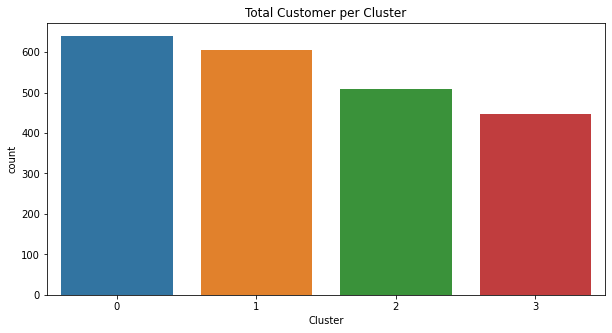

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x=df1['Cluster'])
plt.title('Total Customer per Cluster')
plt.show()

**Cluster 0 :** mid
**Cluster 1 :** high
**Cluster 2 :** extreme high
**Cluster 3 :** low

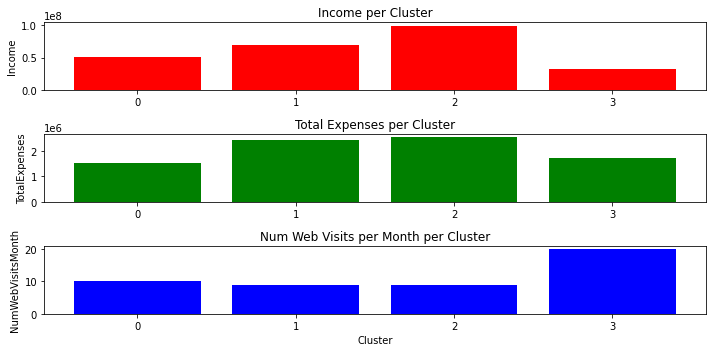

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(10,5))
ax[0].bar(x='Cluster',height='Income',data=df1,color='red')
ax[1].bar(x='Cluster',height='TotalExpenses',data=df1,color='green')
ax[2].bar(x='Cluster',height='NumWebVisitsMonth',data=df1,color='blue')
plt.xlabel('Cluster')
ax[0].set_ylabel('Income')
ax[1].set_ylabel('TotalExpenses')
ax[2].set_ylabel('NumWebVisitsMonth')
ax[0].set_xticks([0,1,2,3])
ax[1].set_xticks([0,1,2,3])
ax[2].set_xticks([0,1,2,3])
ax[0].set_title('Income per Cluster')
ax[1].set_title('Total Expenses per Cluster')
ax[2].set_title('Num Web Visits per Month per Cluster')
plt.tight_layout()
plt.show()

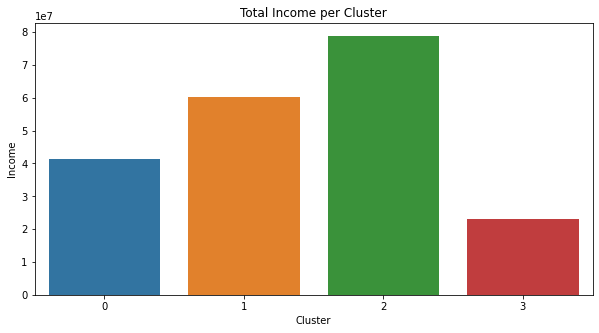

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=df1['Cluster'],y=df1['Income'],ci=True)
plt.title('Total Income per Cluster')
plt.show()

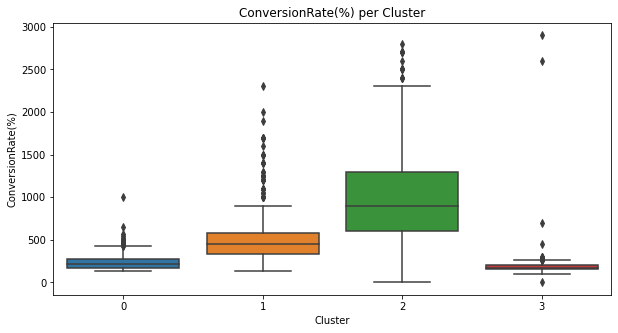

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df1['Cluster'],y=df1['ConversionRate(%)'])
plt.title('ConversionRate(%) per Cluster')
plt.show()

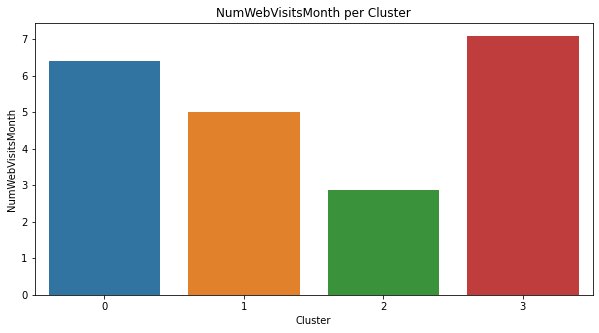

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=df1['Cluster'],y=df1['NumWebVisitsMonth'],ci=True)
plt.title('NumWebVisitsMonth per Cluster')
plt.show()

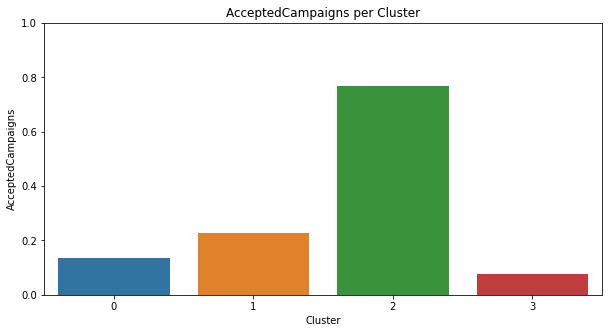

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=df1['Cluster'], y=df1['AcceptedCampaigns'],ci=0)
plt.title('AcceptedCampaigns per Cluster')
plt.ylim([0,1])
plt.show()